In [2]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import combinations

random.seed(30)
df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [3]:
# Convert 'Quarter' to a sequential numeric value based on time order
df['Year'] = df['Quarter'].str.extract(r'(\d{4})').astype(int)
df['Quarter_Num'] = df['Quarter'].str.extract(r'(Q\d)').replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}).astype(int)
df['Quarter_order'] = (df['Year'] - df['Year'].min()) * 4 + (df['Quarter_Num'] - 1)
df

/tmp/ipykernel_969097/577555509.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Quarter_Num'] = df['Quarter'].str.extract(r'(Q\d)').replace({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}).astype(int)


,Quarter,Consumption,Income,Production,Savings,Unemployment,Year,Quarter_Num,Quarter_order
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9,1970,1,0
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5,1970,2,1
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5,1970,3,2
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7,1970,4,3
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1,1971,1,4
...,...,...,...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0,2018,2,193
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3,2018,3,194
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2,2018,4,195
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1,2019,1,196


In [4]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def prepare_data_for_regression(df, target_column, covariates, test_size=40):
    """
    Função para dividir os dados entre treino e teste com normalização Z-score.
    """
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Separar variáveis explicativas e alvo
    X = df[covariates]
    y = df[target_column].values.reshape(-1, 1)

    # Normalizar os dados
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Divisão em treino e teste
    X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
    y_train, y_test = y_scaled[:-test_size], y_scaled[-test_size:]

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

df['Quarter'] = df['Quarter'].apply(lambda x: x.to_timestamp())
df.set_index("Quarter", inplace=True)


In [6]:
from itertools import combinations

def find_best_covariates(df, target_column, covariates, test_size=40):
    """
    Função para encontrar a melhor combinação de covariáveis baseada em MAE.
    """
    best_mae = float("inf")
    best_covariates = []
    results = []

    # Testar todas as combinações possíveis de covariáveis
    for r in range(1, len(covariates) + 1):
        for subset in combinations(covariates, r):
            subset = list(subset)

            # Preparar os dados com o subset de covariáveis
            X_train, X_test, y_train, y_test = prepare_data_for_regression(
                df, target_column, subset, test_size
            )

            # Treinamento do modelo
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Cálculo do MAE
            mae = mean_absolute_error(y_test, y_pred)

            # Salvar resultados
            results.append((subset, mae))
            if mae < best_mae:
                best_mae = mae
                best_covariates = subset

    # Organizar os resultados
    results_df = pd.DataFrame(results, columns=["Covariates", "MAE"]).sort_values(by="MAE")

    return best_covariates, best_mae, results_df

In [10]:

def fit_and_plot_regression(df, target_column, covariates):
    """
    Função para ajustar um modelo de regressão linear múltipla e plotar as previsões.
    Inclui normalização Z-score e reversão para a escala original.
    """
    # Preparar os dados com os escaladores
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_data_for_regression(
        df, target_column, covariates
    )

    # Treinamento do modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_scaled = model.predict(X_test)

    # Reverter previsões e valores de teste para a escala original
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test)

    # Cálculo de métricas na escala original
    mae = mean_absolute_error(y_test_original, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    mase = mean_absolute_scaled_error(
        y_test_original.flatten(), y_pred.flatten(), scaler_y.inverse_transform(y_train)
    )

    # Cálculo do AIC
    n = len(y_test_original)  # Número de observações
    rss = np.sum((y_test_original.flatten() - y_pred.flatten()) ** 2)  # Soma dos resíduos ao quadrado
    k = X_train.shape[1] + 1  # Número de parâmetros (coeficientes + intercepto)
    aic = n * np.log(rss / n) + 2 * k  # Fórmula do AIC

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    print(f"AIC: {aic}")

    # Plot dos resultados
    plt.figure(figsize=(16, 4))
    plt.plot(df.index[:len(y_train)], y_train, label='y_train', color='#0073b3',linestyle='solid', marker="o")
    plt.plot(df.index[-len(y_test):], y_test, label='y_test', color='#dd930e',linestyle='solid', marker="o")
    plt.plot(df.index[-len(y_test_original):], y_pred, label="y_pred", color="#099f74",linestyle='solid', marker="o")


    plt.xlabel("Time")
    plt.ylabel(target_column)
    plt.title("Multiple Linear Regression Predictions with Z-Score Normalization")
    plt.grid(True)
    plt.legend()
    plt.show()


Primeiro, vamos testar com todas as covariáveis, sem nenhuma transformação aplicada.

MAE: 0.11513144763974203
RMSE: 0.14961786029073487
MASE: 0.1883342531877529
AIC: -139.97366668781316


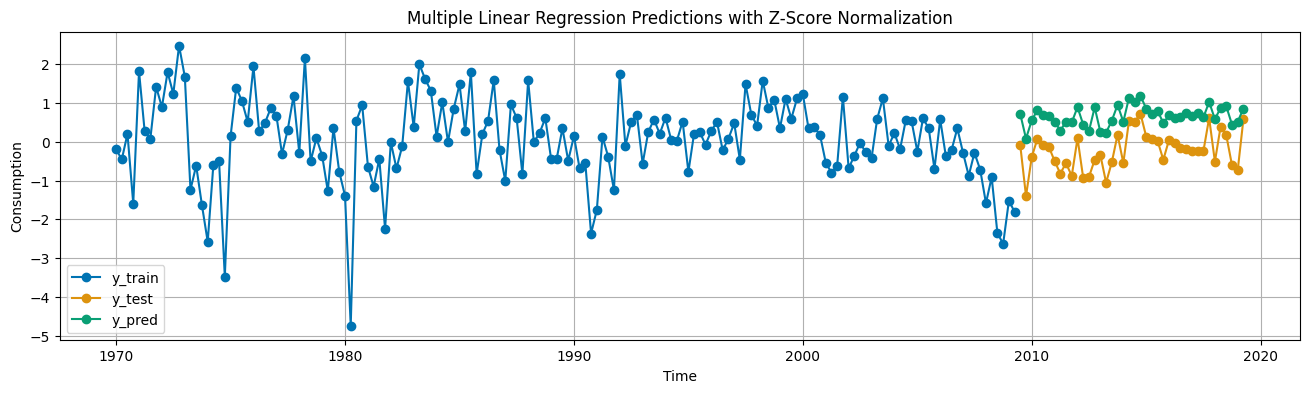

In [11]:
covariates = ["Income", "Production", "Savings", 'Unemployment', 'Quarter_order']

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)

Agora, selecionaremos as variáveis com melhor métrica ajustada.

MAE: 0.09806759679801184
RMSE: 0.1525434101374503
MASE: 0.16042087529954566
AIC: -142.42448534421334


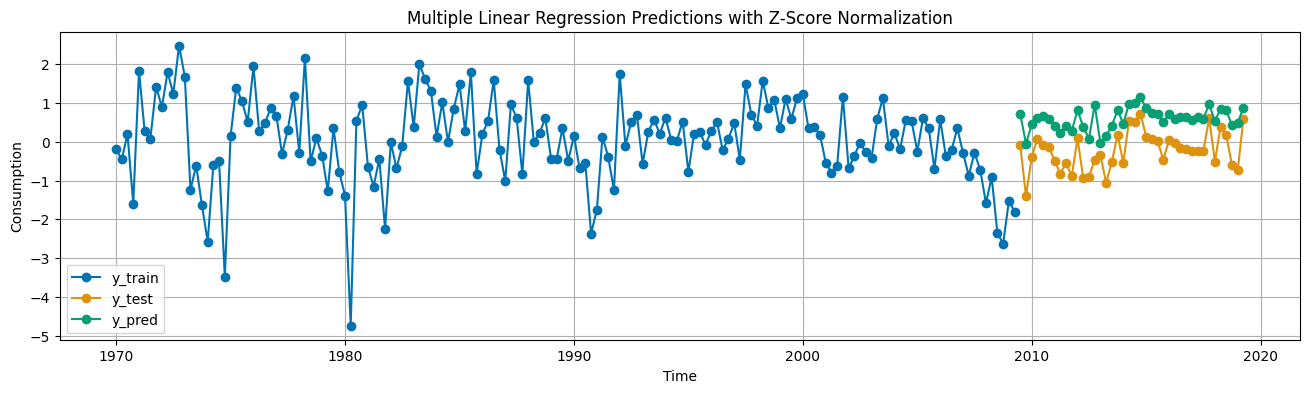

In [12]:
covariates = ["Income", "Savings", 'Quarter_order']

fit_and_plot_regression(df, target_column="Consumption", covariates=covariates)